In [1]:
import os
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from monai.config import print_config
from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.networks.nets import densenet121
from monai.metrics import compute_roc_auc

pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_columns', None)

np.random.seed(0)
#print_config()

In [2]:
# Cohort read
working_directory = '/mnt/datasets/fastcovnet/'
columnToPredict = 'Case_type'
resolution = '224'
data = pd.read_csv(os.path.join(working_directory,'filtered_cohort.csv'),"|")
#path_saved_model = os.path.expanduser("~")+'/best_metric_'+columnToPredict+'_'+resolution+'.pth'

epoch_num = 100

In [3]:
data.head()

,PatientId,SEXE,EDAT_EXPOSICIO,DATA_PRIMERA_PCR_POSITIVA,EXITUS,DATA_EXITUS,StudyDescription,Estudi_data,Dies_desde_positiu,Source,InstitutionName,id,AcquisitionDeviceProcessingDescription,BodyPartExamined,DetectorManufacturerName,DetectorManufacturerModelName,DeviceSerialNumber,Manufacturer,ManufacturerModelName,Modality,PerformedProcedureStepDescription,ProtocolName,RequestedProcedureDescription,StudyInstanceUID,StudyTime,ViewPosition,path,filename,Case_type,jpg_full_path
0,8041157,Dona,64,2020-04-02,No,NaN,Rx de tòrax 1-2 projeccions (F i P),2018-12-30T13:27:37.000Z,-458.0,H08002022,HOSPITAL GERMANS TRIAS Y PUJOL,211576,"UNIQUE: S:200 L:4.0 FC d:1,8 g:0,6 sb:2 eq:-0,4 nr:0 dc:3 bal...",CHEST,TRIXELL,PIXIUM4600,963334011495,Philips Medical Systems,DigitalDiagnost,DX,RA00001,Tórax,Rx de tòrax 1-2 projeccions (F i P),1.2.826.0.1.3680043.2.403.41.1181230130515226.1.3450,132737,PA,/mnt/datasets/fastcovnet/dicoms/,1.3.46.670589.30.1.6.1.963334011495.1546172949046.2.dcm,Control,/mnt/datasets/fastcovnet/jpg/224/1.3.46.670589.30.1.6.1.963334011495.1546172949046.2.jpg
1,8179140,Home,69,2020-03-26,No,NaN,Rx de tòrax 1-2 projeccions (F i P),2020-01-03T05:19:22.000Z,-82.0,H08810319,C.S. VALLE DE HEBRON,211563,"UNIQUE: S:200 L:4.0 FC d:1,8 g:0,6 sb:2 eq:-0,4 nr:0 dc:3 bal...",CHEST,TRIXELL,PIXIUM4600,963333829407,Philips Medical Systems,DigitalDiagnost,DX,Rx de tòrax 1-2 projeccions (F i P),Tórax,NaN,1.2.826.0.1.3680043.2.403.114.1200103040800820.1.345049622443,51922,PA,/mnt/datasets/fastcovnet/dicoms/,1.3.46.670589.30.1.6.1.963333829407.1578028817843.2.dcm,Control,/mnt/datasets/fastcovnet/jpg/224/1.3.46.670589.30.1.6.1.963333829407.1578028817843.2.jpg
2,3279980,Home,44,2020-03-22,No,NaN,Rx de tòrax 1-2 projeccions (F i P),2019-09-07T03:00:13.000Z,-196.0,H08810319,C.S. VALLE DE HEBRON,211603,"UNIQUE: S:200 L:4.0 FC d:1,8 g:0,6 sb:2 eq:-0,4 nr:0 dc:3 bal...",CHEST,TRIXELL,PIXIUM4600,963333829407,Philips Medical Systems,DigitalDiagnost,DX,Rx de tòrax 1-2 projeccions (F i P),Tórax,NaN,1.2.826.0.1.3680043.2.403.114.1190907025102058.1.345049622443,30013,PA,/mnt/datasets/fastcovnet/dicoms/,1.3.46.670589.30.1.6.1.963333829407.1567825267546.2.dcm,Control,/mnt/datasets/fastcovnet/jpg/224/1.3.46.670589.30.1.6.1.963333829407.1567825267546.2.jpg
3,3966827,Home,84,2020-04-13,Si,2020-04-15 00:00:00,Rx de tòrax 1-2 projeccions (F i P),2019-09-13T03:46:22.000Z,-212.0,H08002022,HOSPITAL GERMANS TRIAS Y PUJOL,211615,"UNIQUE: S:200 L:4.0 FC d:1,8 g:0,6 sb:2 eq:-0,4 nr:0 dc:3 bal...",CHEST,TRIXELL,PIXIUM4600,963334011495,Philips Medical Systems,DigitalDiagnost,DX,RA00001,Tórax,Rx de tòrax 1-2 projeccions (F i P),1.2.826.0.1.3680043.2.403.41.1190913034425902.1.3450,34622,PA,/mnt/datasets/fastcovnet/dicoms/,1.3.46.670589.30.1.6.1.963334011495.1568339237156.2.dcm,Control,/mnt/datasets/fastcovnet/jpg/224/1.3.46.670589.30.1.6.1.963334011495.1568339237156.2.jpg
4,4180225,Dona,75,2020-04-08,No,NaN,Torax PA-L,2020-04-06T23:40:41.000Z,-1.0,H08858656,Hospital Moises Broggi,211647,"UNIQUE: S:200 L:4.0 FC d:1,8 g:0,6 sb:2 eq:-0,4 nr:0 dc:3 bal...",CHEST,TRIXELL,PIXIUM4600,963333689245,Philips Medical Systems,DigitalDiagnost,DX,Torax PA-L,Tórax,Torax PA-L,1.2.840.113845.11.1000000001973866488.20200406232747.4006825,234041,PA,/mnt/datasets/fastcovnet/dicoms/,1.3.46.670589.30.1.6.1.963333689245.1586209370734.2.dcm,Case,/mnt/datasets/fastcovnet/jpg/224/1.3.46.670589.30.1.6.1.963333689245.1586209370734.2.jpg


In [4]:
# jpg full path creation
# data["jpg_full_path"] = data["path"].replace({'/dicoms/': '/jpg/'}, regex=True)+resolution +'/'+data["filename"].replace({'.dcm': '.jpg'}, regex=True)

# Classes to predict
class_names = sorted(data[columnToPredict].unique())
num_class = len(class_names)
data[columnToPredict].value_counts()

Case       4713
Control    3133
Name: Case_type, dtype: int64

In [5]:
image_files = [data[data[columnToPredict]==x].loc[:,"jpg_full_path"].tolist() for x in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))   # Creates an array of 0 or 1 with a length of that category
num_total = len(image_label_list)     # Number of images

In [6]:
image_file_list[1]

'/mnt/datasets/fastcovnet/jpg/224/1.3.46.670589.30.1.6.1.963333829407.1584817541171.2.jpg'

In [16]:
# Cohort read
data = pd.read_csv(os.path.join(working_directory,'cohort_covid_20201110.csv'),"|")

# It's already done during cohort creation, but just in case we've a different columnToPredict or just to be sure we have it as string and not number.
# NULL removal of predicted variable
data = data[data[columnToPredict].isna()==False]

# Convert columnToPredict to string, just in case they're numbers, so we don't have any errors.
data[columnToPredict] = data[columnToPredict].astype(str)

# Classes to predict
class_names = sorted(data[columnToPredict].unique())
num_class = len(class_names)
data[columnToPredict].value_counts()

data[columnToPredict] = pd.Categorical(data[columnToPredict])
data["to_predict"] = data[columnToPredict].cat.codes
dict(enumerate(data[columnToPredict].cat.categories))

image_file_list = data.path_jpg.tolist()
image_label_list = data.to_predict.tolist()

num_total = len(image_label_list) 

In [17]:
image_file_list[2]

'/mnt/datasets/SIMDCAT/jpg/224/2020_04/1.3.46.670589.30.1.6.1.963334011535.1586135118125.3.jpg'

In [10]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

# Data is already random, so we can create datasets sequentially

for i in range(num_total):
    if i < (valid_frac * num_total):
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif i < ((valid_frac + test_frac) * num_total):
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),",  Validation count =", len(valX), ",  Test count =",len(testX))

Training count = 6276 ,  Validation count = 785 ,  Test count = 785


In [11]:
trainX[1]

'/mnt/datasets/fastcovnet/jpg/224/1.3.46.670589.30.1.6.1.963333689245.1585324620640.2.jpg'

In [12]:
train_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

val_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

In [13]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=100, shuffle=False, num_workers=10)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=100, num_workers=10)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=100, num_workers=10)

In [14]:
train_ds.image_files[1]# train_ds.labels[1] -> 1

'/mnt/datasets/fastcovnet/jpg/224/1.3.46.670589.30.1.6.1.963333689245.1585324620640.2.jpg'

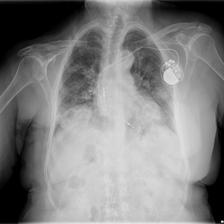

In [15]:
Image.open(image_file_list[1])